# Fruit multiclassification

- Fabio Villa ()
- Luca Perfetti ()
- Francesco Cavallini (920835)

Volgiamo realizzare un progetto che, letto un [dataset contenente diversi istanze di frutti ripotati di 360](https://www.kaggle.com/datasets/moltean/fruits/code), implementi un modello di rete neurale (basato su CNN) che permetta la multi calssificazione dei vari gruppi di frutta.fornita. Ossia, più nello specifico, vogliamo creare diverse istanze di reti neurali (sotto forma modalità trial and error) per arrivare a vedere quali sono le performmance più realistiche possibiili che possiamo ottenere addestrando una rete neurale per predirre due label; dove le label in questione rappresentano:
- label 1: categoria generale di frutto (eg: "apple")
- label 2: sotto-categoria di frutto (eg: "apple golden", "apple red", ...)


## Setup

Semplice sezione di setup delle librerie e del dirve

In [34]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet101, VGG19
import matplotlib.image as mpimg
from anytree import Node, RenderTree
from anytree.exporter import DotExporter

## Lettura dataset

Dalla documentazione si evice che il dataset a nostra disposizione contiene 141 istanze di diversi frutti che vengono fatti ruotare di 360 gradi. Ma si nota che i dati a nostra disposizione non sono perfettamente integri, per questo motivo i dati vengono modificati manualmente (eliminando circa 20 classi) per garantire l'integrità dei dati. Questo step verrà meglio spiegto nella relazione.

Di seguito procediamo con la lettura del dataset che abbiamo mantenuto:

In [2]:
dataset_path = r"C:\Users\lperf\OneDrive\Desktop\Magistrale\2° Anno\Advanced Machine Learning\Assignement\Project\TrainingFabio_Extracted_data"

### Setup dei dictionaries

Inizializzazione di dictionary che associa labels_2 (eg: "apple golden") ad un numero intero

In [3]:
# Initialize dictionaries and lists
labels_2_int = {}
labels_1_array = []

# Iterate over the subdirectories in the order they appear
dataset_dir = os.path.join(dataset_path, "train")
for i, folder_name in enumerate(sorted(os.listdir(dataset_dir))):
    labels_2_int[folder_name] = i
    print(folder_name)

    first_part = folder_name.split(' ')[0]
    if first_part not in labels_1_array:  # Keeps the first occurrence
        labels_1_array.append(first_part)

Apple Braeburn
Apple Crimson Snow
Apple Golden
Apple Granny Smith
Apple Hit
Apple Pink Lady
Apple Red
Apple Red Delicious
Apple Red Yellow
Apricot
Avocado Ripe
Avocado Unripe
Banana Classic
Banana Lady Finger
Banana Red
Beetroot
Blueberry
Cabbage White
Cactus Fruit
Cantaloupe Classic
Cantaloupe Yellow
Carambula
Carrot
Cauliflower
Cherry Rainier
Cherry Wax Black
Cherry Wax Red
Cherry Wax Yellow
Chestnut
Clementine
Cocos
Corn Classic
Corn Husk
Cucumber Ripe
Cucumber Unripe
Dates
Eggplant Classic
Eggplant Long
Fig
Ginger Root
Granadilla
Grape Blue
Grape Pink
Grape White
Grapefruit Pink
Grapefruit White
Guava
Hazelnut
Huckleberry
Kaki
Kiwi
Kohlrabi
Kumquats
Lemon Classic
Lemon Meyer
Limes
Lychee
Mandarine
Mango Red
Mango Unripe
Mangostan
Maracuja
Melon Piel De Sapo
Mulberry
Nectarine Classic
Nectarine Flat
Nut Forest
Nut Pecan
Onion Red
Onion Red Peeled
Onion White
Orange
Papaya
Passion Fruit
Peach Classic
Peach Flat
Peach Yellow
Pear Abate
Pear Forelle
Pear Hit
Pear Kaiser
Pear Monster
Pe

In [4]:
labels_2_int

{'Apple Braeburn': 0,
 'Apple Crimson Snow': 1,
 'Apple Golden': 2,
 'Apple Granny Smith': 3,
 'Apple Hit': 4,
 'Apple Pink Lady': 5,
 'Apple Red': 6,
 'Apple Red Delicious': 7,
 'Apple Red Yellow': 8,
 'Apricot': 9,
 'Avocado Ripe': 10,
 'Avocado Unripe': 11,
 'Banana Classic': 12,
 'Banana Lady Finger': 13,
 'Banana Red': 14,
 'Beetroot': 15,
 'Blueberry': 16,
 'Cabbage White': 17,
 'Cactus Fruit': 18,
 'Cantaloupe Classic': 19,
 'Cantaloupe Yellow': 20,
 'Carambula': 21,
 'Carrot': 22,
 'Cauliflower': 23,
 'Cherry Rainier': 24,
 'Cherry Wax Black': 25,
 'Cherry Wax Red': 26,
 'Cherry Wax Yellow': 27,
 'Chestnut': 28,
 'Clementine': 29,
 'Cocos': 30,
 'Corn Classic': 31,
 'Corn Husk': 32,
 'Cucumber Ripe': 33,
 'Cucumber Unripe': 34,
 'Dates': 35,
 'Eggplant Classic': 36,
 'Eggplant Long': 37,
 'Fig': 38,
 'Ginger Root': 39,
 'Granadilla': 40,
 'Grape Blue': 41,
 'Grape Pink': 42,
 'Grape White': 43,
 'Grapefruit Pink': 44,
 'Grapefruit White': 45,
 'Guava': 46,
 'Hazelnut': 47,
 'Hu

In [5]:
labels_1_array

['Apple',
 'Apricot',
 'Avocado',
 'Banana',
 'Beetroot',
 'Blueberry',
 'Cabbage',
 'Cactus',
 'Cantaloupe',
 'Carambula',
 'Carrot',
 'Cauliflower',
 'Cherry',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Cucumber',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger',
 'Granadilla',
 'Grape',
 'Grapefruit',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Limes',
 'Lychee',
 'Mandarine',
 'Mango',
 'Mangostan',
 'Maracuja',
 'Melon',
 'Mulberry',
 'Nectarine',
 'Nut',
 'Onion',
 'Orange',
 'Papaya',
 'Passion',
 'Peach',
 'Pear',
 'Pepino',
 'Pepper',
 'Physalis',
 'Pineapple',
 'Pitahaya',
 'Plum',
 'Pomegranate',
 'Pomelo',
 'Potato',
 'Quince',
 'Rambutan',
 'Raspberry',
 'Redcurrant',
 'Salak',
 'Strawberry',
 'Tamarillo',
 'Tangelo',
 'Tomato',
 'Walnut',
 'Watermelon',
 'Zucchini']

Inizializzazione di un dictionary che associa labels_1 (eg: "appple") ad un numero intero

In [6]:
labels_1_int = {}
for i, fruit_name in enumerate(labels_1_array):
    # Map folder name to an integer
    labels_1_int[fruit_name] = i

In [7]:
labels_1_int

{'Apple': 0,
 'Apricot': 1,
 'Avocado': 2,
 'Banana': 3,
 'Beetroot': 4,
 'Blueberry': 5,
 'Cabbage': 6,
 'Cactus': 7,
 'Cantaloupe': 8,
 'Carambula': 9,
 'Carrot': 10,
 'Cauliflower': 11,
 'Cherry': 12,
 'Chestnut': 13,
 'Clementine': 14,
 'Cocos': 15,
 'Corn': 16,
 'Cucumber': 17,
 'Dates': 18,
 'Eggplant': 19,
 'Fig': 20,
 'Ginger': 21,
 'Granadilla': 22,
 'Grape': 23,
 'Grapefruit': 24,
 'Guava': 25,
 'Hazelnut': 26,
 'Huckleberry': 27,
 'Kaki': 28,
 'Kiwi': 29,
 'Kohlrabi': 30,
 'Kumquats': 31,
 'Lemon': 32,
 'Limes': 33,
 'Lychee': 34,
 'Mandarine': 35,
 'Mango': 36,
 'Mangostan': 37,
 'Maracuja': 38,
 'Melon': 39,
 'Mulberry': 40,
 'Nectarine': 41,
 'Nut': 42,
 'Onion': 43,
 'Orange': 44,
 'Papaya': 45,
 'Passion': 46,
 'Peach': 47,
 'Pear': 48,
 'Pepino': 49,
 'Pepper': 50,
 'Physalis': 51,
 'Pineapple': 52,
 'Pitahaya': 53,
 'Plum': 54,
 'Pomegranate': 55,
 'Pomelo': 56,
 'Potato': 57,
 'Quince': 58,
 'Rambutan': 59,
 'Raspberry': 60,
 'Redcurrant': 61,
 'Salak': 62,
 'Strawbe

Questi due dictionaries sono poi utili alla lettura del dataset, siccome, con questi possiamo assegnare ad ogni classe un intero

### Creazione dei file numpy array

Si definisce la seguente funzione adibita a crare dei file .npz (numpy array) che serviranno successivamente a leggere l'intero dataset instantaneamente (invece che dover attendere lunghi tempi di attesa solo per caricare il dataset)

In [8]:
def preprocess_and_save(input_dir, output_file, show_images=False):
    data = []
    # categoria generale (es mela)
    labels_1 = []
    # categoria specifica (es mela golden)
    labels_2 = []

    # support variables for plotting
    already_printed = []
    images_to_plot = []
    labels_to_plot = []

    class_names = sorted(os.listdir(input_dir))  # Assicura ordine costante delle classi
    for _, class_name in enumerate(class_names):
        class_dir = os.path.join(input_dir, class_name)

        # Use os.path.split to correctly handle path separators in a platform-independent way
        _, folder_name = os.path.split(class_dir)

        label_1 = labels_1_int[folder_name.split(' ')[0]]  # Access label_1
        label_2 = labels_2_int[folder_name]              # Access label_2

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=(128, 128))  # Ridimensiona
            img_array = img_to_array(img) / 255.0  # Normalizza
            data.append(img_array)
            labels_1.append(label_1)
            labels_2.append(label_2)

            # Store image and label for plotting
            if label_2 not in already_printed:
                images_to_plot.append(img)
                labels_to_plot.append(folder_name)  # Use folder_name directly
                already_printed.append(label_2)

    if show_images:
        # Plot images and labels
        num_images = len(images_to_plot)
        num_cols = 10
        num_rows = (num_images + num_cols - 1) // num_cols

        plt.figure(figsize=(20, num_rows * 2))
        for i in range(num_images):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(images_to_plot[i])
            plt.title(labels_to_plot[i])
            plt.axis('off')
        plt.show()
        #save image to file
        plt.savefig('plot.png')

    # Converti in array numpy
    data = np.array(data)
    labels_1 = np.array(labels_1)
    labels_2 = np.array(labels_2)

    # Controllo se è train o validation per applicare lo shuffle
    if 'train' in input_dir:
        indices = np.random.permutation(len(data))  # Genera indici casuali
        data = data[indices]
        labels_1 = labels_1[indices]
        labels_2 = labels_2[indices]
        print("shuffle eseguito")
    else:
        print("shuffle solo per il train")

    # Salva i dati
    np.savez(output_file, x=data, y1=labels_1, y2=labels_2)

Di seguito viene chimata la funzione per creare i file di train/test/validation sets:

#### File train

Nota che in questo caso viene anche plottato un grafico che mostra un sample per ogni frutto disponibile nel nostro dataset. Questo plot è stato poi salvato in memoria di modo da porter comunque venire visualizzato anche quando non si esegue la funzione mostrata precedentemente:

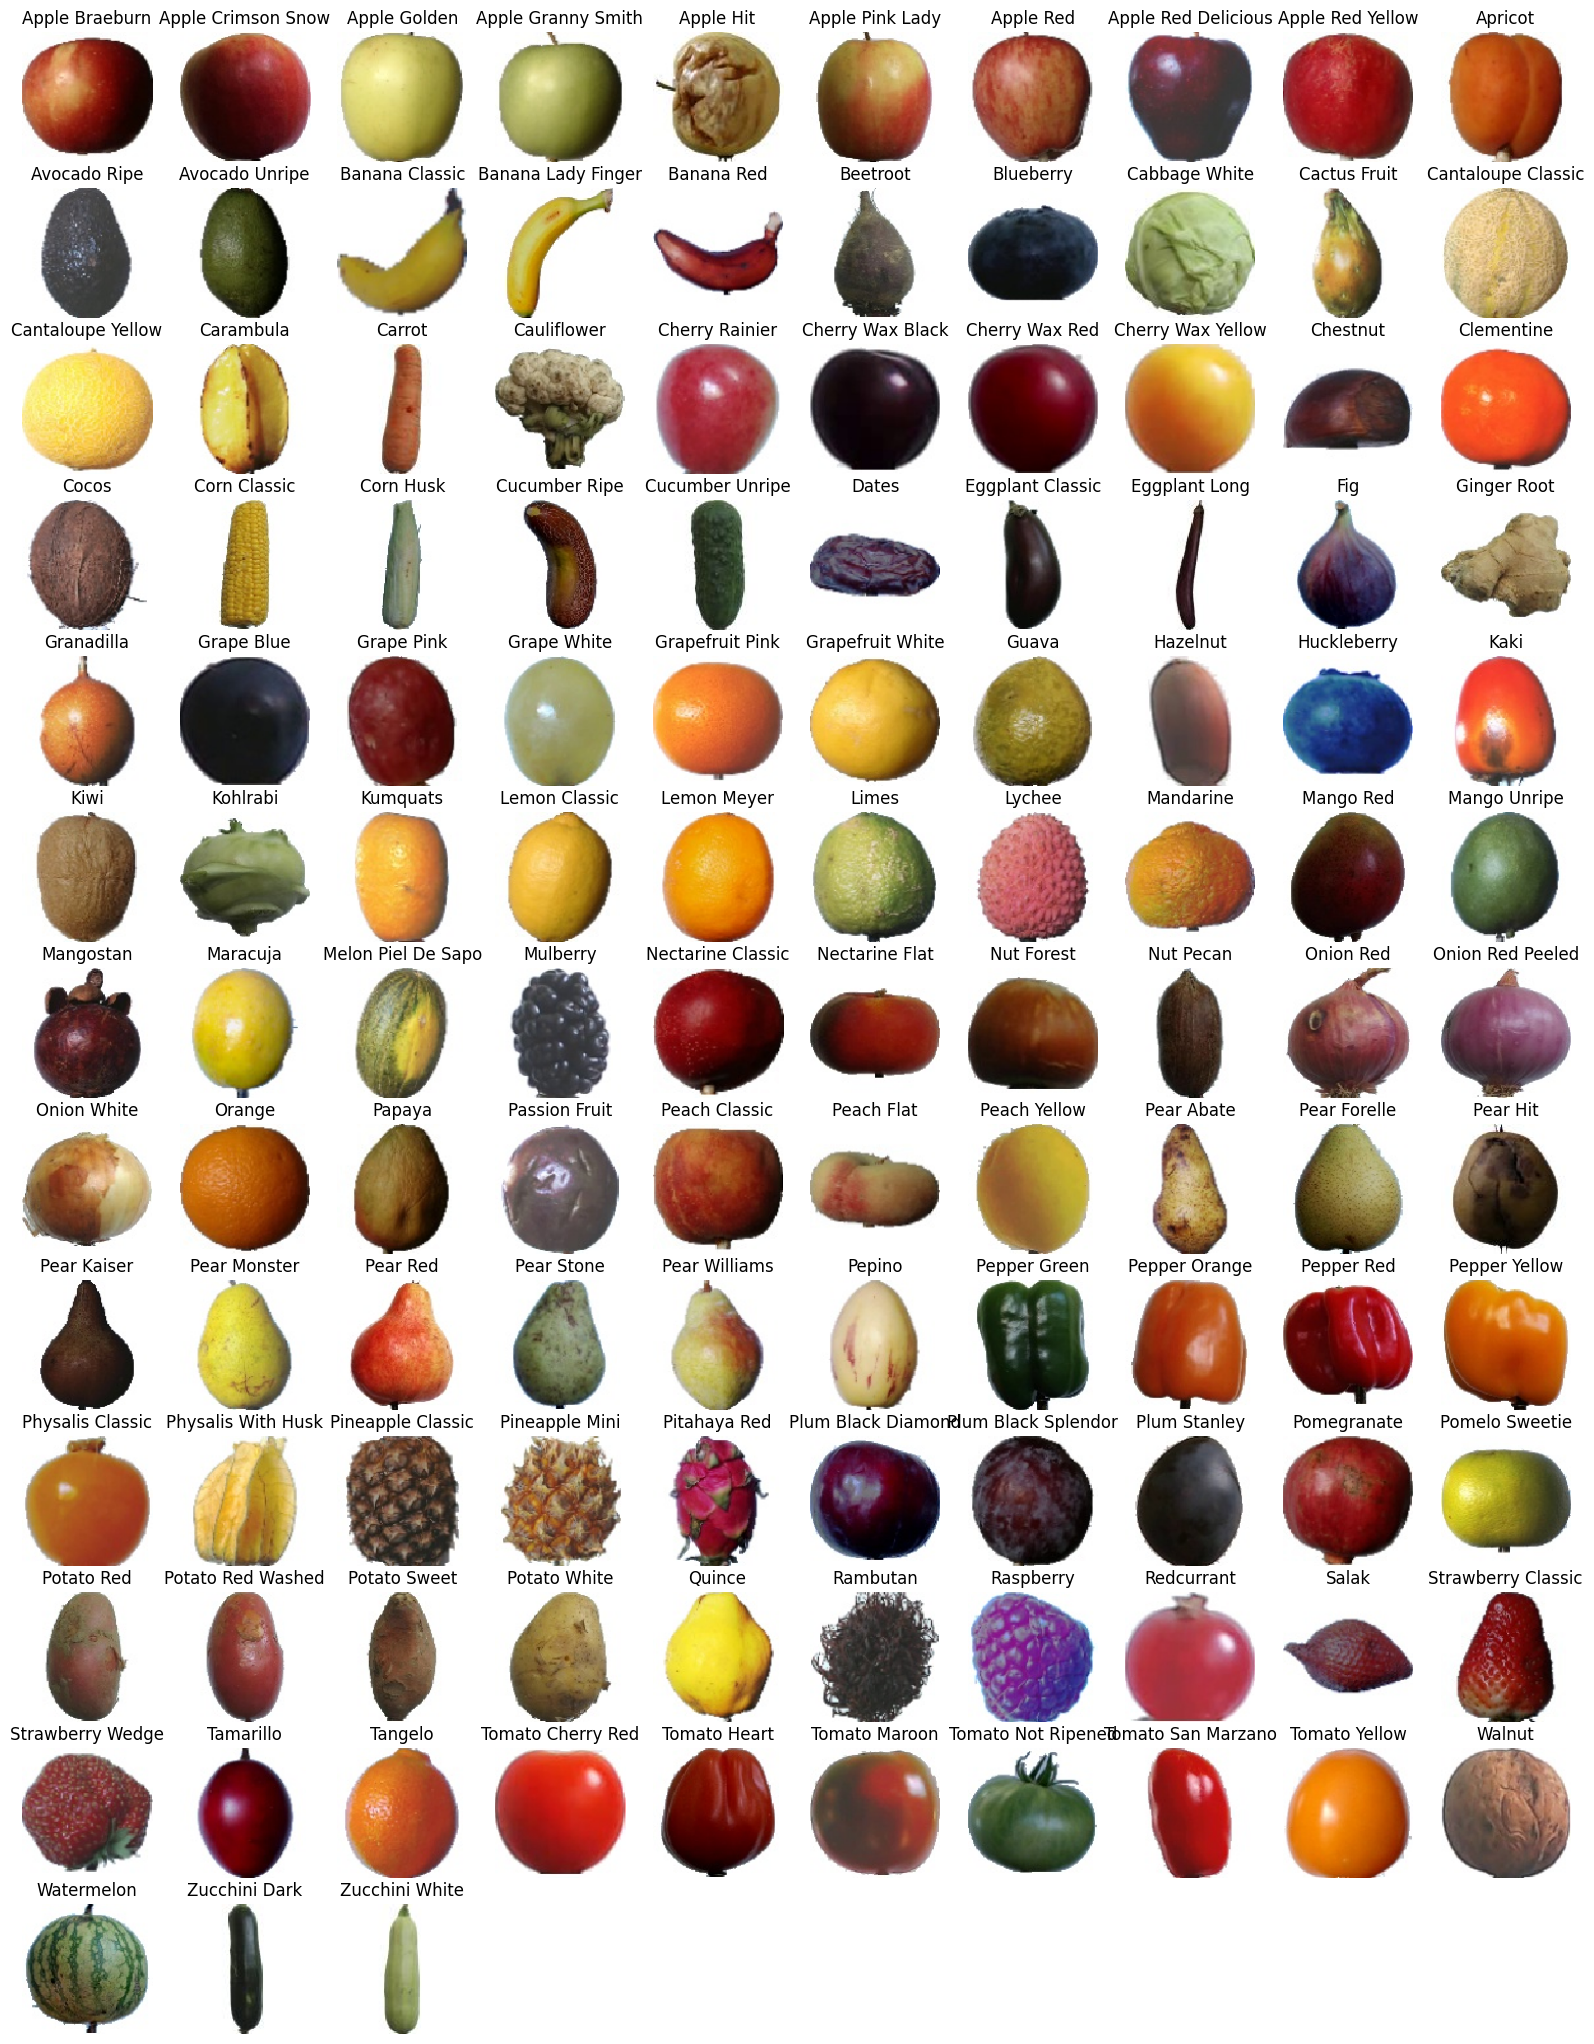

shuffle eseguito


<Figure size 640x480 with 0 Axes>

In [28]:
#train_path = dataset_path + 'train_data_BIG.npz'
train_path = 'train_data_BIG.npz'
# check if npz file already exists
if not os.path.exists(train_path):
    preprocess_and_save(dataset_path+'\\train', train_path, show_images=True)
else:
    image_path = r"C:\Users\lperf\OneDrive\Desktop\Magistrale\2° Anno\Advanced Machine Learning\Assignement\Project\TrainingFabio_Extracted_data"
    # plot local image using plt
    img = mpimg.imread(image_path + '\\plot.png')
    # Create a figure with a large size
    fig, ax = plt.subplots(figsize=(12, 12))  # Adjust size as needed

    # Display the image
    ax.imshow(img)

    # Maximize the axis size by turning off the spines and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the image
    plt.show()

#### File validazione

scrittura file validation set con la stessa funzione

In [29]:
val_path = 'val_data_BIG.npz'
# check if npz file already exists
if not os.path.exists(val_path):
    preprocess_and_save(dataset_path + '\\val', val_path)

shuffle solo per il train


#### File test

scrittura file test set con la stessa funzione

In [30]:
test_path ='test_data_BIG.npz'
# check if npz file already exists
if not os.path.exists(test_path):
    preprocess_and_save(dataset_path+'\\test', test_path)

shuffle solo per il train


### Lettura file numpy array

Una volta che i file numpy array sono stati salvati è possibile leggerli direttamente, avere lo step precedente che ci salva tutti i dati in formato file e poi leggerli in questo step rende la lettura compilazione del file molto lenta (cosa che non ci interessa perchè dobbiamo farlo una sola volta) ma la lettura di tutto il dataset molto veloce.

In [10]:
train_path = r"C:\Users\lperf\OneDrive\Desktop\Magistrale\2° Anno\Advanced Machine Learning\Assignement\Project\train_data_BIG.npz"
test_path = r"C:\Users\lperf\OneDrive\Desktop\Magistrale\2° Anno\Advanced Machine Learning\Assignement\Project\test_data_BIG.npz"
val_path = r"C:\Users\lperf\OneDrive\Desktop\Magistrale\2° Anno\Advanced Machine Learning\Assignement\Project\val_data_BIG.npz"

# load train data
data_train = np.load(train_path)
x_train, y1_train, y2_train = data_train['x'], data_train['y1'], data_train['y2']

# Load validation data
data_val = np.load(test_path)
x_val, y1_val, y2_val = data_val['x'], data_val['y1'], data_val['y2']

# Load test data
data_test = np.load(val_path)
x_test, y1_test, y2_test = data_test['x'], data_test['y1'], data_test['y2']

### Pre-Processing: one-hot-encoding delle label

Per ora le label precedentemente salvate sono state create in formato numerico (classe "apple"-->0, classe "pear"-->1, ...). In questa sezione si procede con il one-hot di tutte le label, che, in teoria, dovrebbe migliorare le perfomance di train in quanto abbiamo così che tutti i dati di label sono compresi nel range [0-1]

In [11]:
y1_train = to_categorical(y1_train, num_classes=70)
y1_val = to_categorical(y1_val, num_classes=70)
y1_test = to_categorical(y1_test, num_classes=70)

In [12]:
y2_train = to_categorical(y2_train, num_classes=123)
y2_val = to_categorical(y2_val, num_classes=123)
y2_test = to_categorical(y2_test, num_classes=123)

Si sceglie di applicare direttamente questo step in fase di lettura dei dati in quanto non comporta alcuna modifica significativa al valore informativo delle informazioni, tutti i dati possono venire comunque letti come se non avesssimo fatto alcuna modifica.

## Anlisi esplorativa

Prima di procedere con la preparazione dei dati si fa' una breve analisi esplorativa, per osservare se ci sono alcune incoformità nel dataset precedentemente processato e per cercare attributi particolari che magari hanno bisono di essere sistemati in fase di preparazione dati pre-train.

### Numero di classi

Abbiamo dunque che il numero di classi per i 2 tipi di label:

In [13]:
num_object_label_1 = y1_train.shape[1]
num_object_label_2 = y2_train.shape[1]
print(f"Numero di classi per label_1: {num_object_label_1}")
print(f"Numero di classi per label_2: {num_object_label_2}")

Numero di classi per label_1: 70
Numero di classi per label_2: 123


### Bilanciamento del dataset

In particolare, se andiamo ad esplorare il numero di dati presenti per ogni label e sotto-label otteniamo il seguente albero:

In [14]:
# Contiamo il numero di occorrenze per ogni etichetta secondaria
y2_counts = np.sum(y2_train, axis=0)  # Conta le occorrenze di ogni classe secondaria

# Creiamo una struttura ad albero
root = Node("Frutti")  # Nodo radice
primary_nodes = {}

# Aggiungi nodi per le label primarie
for primary_label in labels_1_int:
    primary_nodes[primary_label] = Node(f"{primary_label} (0)", parent=root)

# Aggiungi nodi per le label secondarie con conteggio
for class_name, index in labels_2_int.items():
    primary_label = class_name.split(' ')[0]  # Estrarre la label primaria
    count = int(y2_counts[index])  # Numero di occorrenze per questa classe
    if primary_label in primary_nodes:
        Node(f"{class_name} ({count})", parent=primary_nodes[primary_label])

# Aggiorna i conteggi delle label primarie
for primary_label, node in primary_nodes.items():
    total_count = sum(
        int(child.name.split("(")[-1].strip(")")) for child in node.children
    )
    node.name = f"{primary_label} ({total_count})"

# Stampa l'albero con conteggi
for pre, _, node in RenderTree(root):
    print(f"{pre}{node.name}")

Frutti
├── Apple (3375)
│   ├── Apple Braeburn (393)
│   ├── Apple Crimson Snow (355)
│   ├── Apple Golden (393)
│   ├── Apple Granny Smith (393)
│   ├── Apple Hit (491)
│   ├── Apple Pink Lady (319)
│   ├── Apple Red (344)
│   ├── Apple Red Delicious (343)
│   └── Apple Red Yellow (344)
├── Apricot (344)
│   └── Apricot (344)
├── Avocado (641)
│   ├── Avocado Ripe (343)
│   └── Avocado Unripe (298)
├── Banana (1001)
│   ├── Banana Classic (343)
│   ├── Banana Lady Finger (315)
│   └── Banana Red (343)
├── Beetroot (315)
│   └── Beetroot (315)
├── Blueberry (323)
│   └── Blueberry (323)
├── Cabbage (100)
│   └── Cabbage White (100)
├── Cactus (343)
│   └── Cactus Fruit (343)
├── Cantaloupe (688)
│   ├── Cantaloupe Classic (344)
│   └── Cantaloupe Yellow (344)
├── Carambula (343)
│   └── Carambula (343)
├── Carrot (105)
│   └── Carrot (105)
├── Cauliflower (491)
│   └── Cauliflower (491)
├── Cherry (1548)
│   ├── Cherry Rainier (516)
│   ├── Cherry Wax Black (344)
│   ├── Cherry Wax Red

Osservando i dati euristicamente sembra che ogni sotto-classe (label_2) abbia più o meno lo stesso numero di sample (circa 300), mentre invece il numero di sample per le classi principali (label) è molto più sbilanciato.  Procediamo quindi a a possiamo studiare più nel dettaglio la distrubuzione di classi e sottoclassi con la seguente funzione:

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(y_train, label_names, title="Distribuzione delle etichette"):
    """
    Visualizza la distribuzione delle etichette in un dataset.

    :param y_train: array numpy (one-hot encoded)
    :param label_names: lista dei nomi delle classi
    :param title: titolo del grafico
    """
    # Converti one-hot encoding in indici delle classi
    class_indices = np.argmax(y_train, axis=1)  # Trova la classe con valore massimo

    # Conta la frequenza di ogni classe
    label_counts = Counter(class_indices)

    # Estrai etichette e frequenze
    labels = [label_names[idx] for idx in label_counts.keys()]
    values = list(label_counts.values())

    # Imposta la figura con due sottotrame
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Diagramma a torta
    axes[0].pie(values, labels=labels, startangle=90, colors=plt.cm.tab20.colors, autopct='%1.1f%%')
    axes[0].set_title(f"{title} (Pie Chart)")
    axes[0].axis('equal')  # Assicura che il diagramma sia un cerchio

    # Diagramma a barre
    axes[1].bar(labels, values, color=plt.cm.tab20.colors[:len(labels)])
    axes[1].set_title(f"{title} (Bar Chart)")
    axes[1].set_xlabel("Etichette")
    axes[1].set_ylabel("Frequenza")
    axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Rimuove le etichette

    # Mostra il grafico
    plt.tight_layout()
    plt.show()

### Studio delle frequenze per label_2 (sotto-classe)

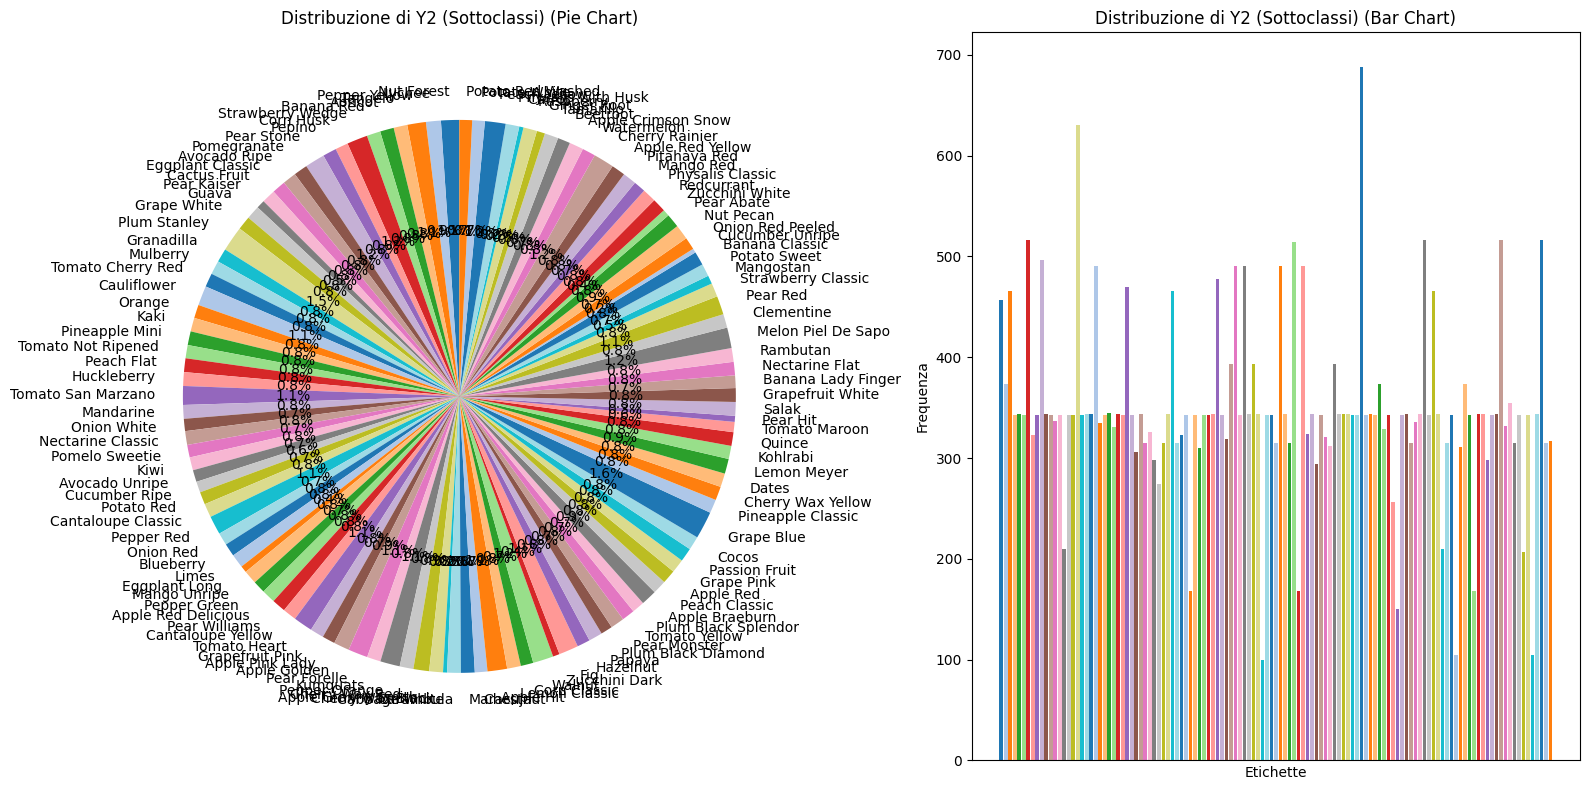

In [16]:
# Plot distribuzione di y2_train
label_names_y2 = list(labels_2_int.keys())  # Nomi per y2
plot_label_distribution(y2_train, label_names_y2, title="Distribuzione di Y2 (Sottoclassi)")

Dai grafici appena mostrati ci possiamo ricredere, risulta infatti eviddente (specialmente dal diagramma a barre) che seppur la maggior parte delle classi abbia un numero vicino alle 300 istanze ci sono comunque molte altre classi che hanno o un numero minore di 250 samples o maggiore di 350. Queste venngono meglio visualizzate nel prossimo plot:

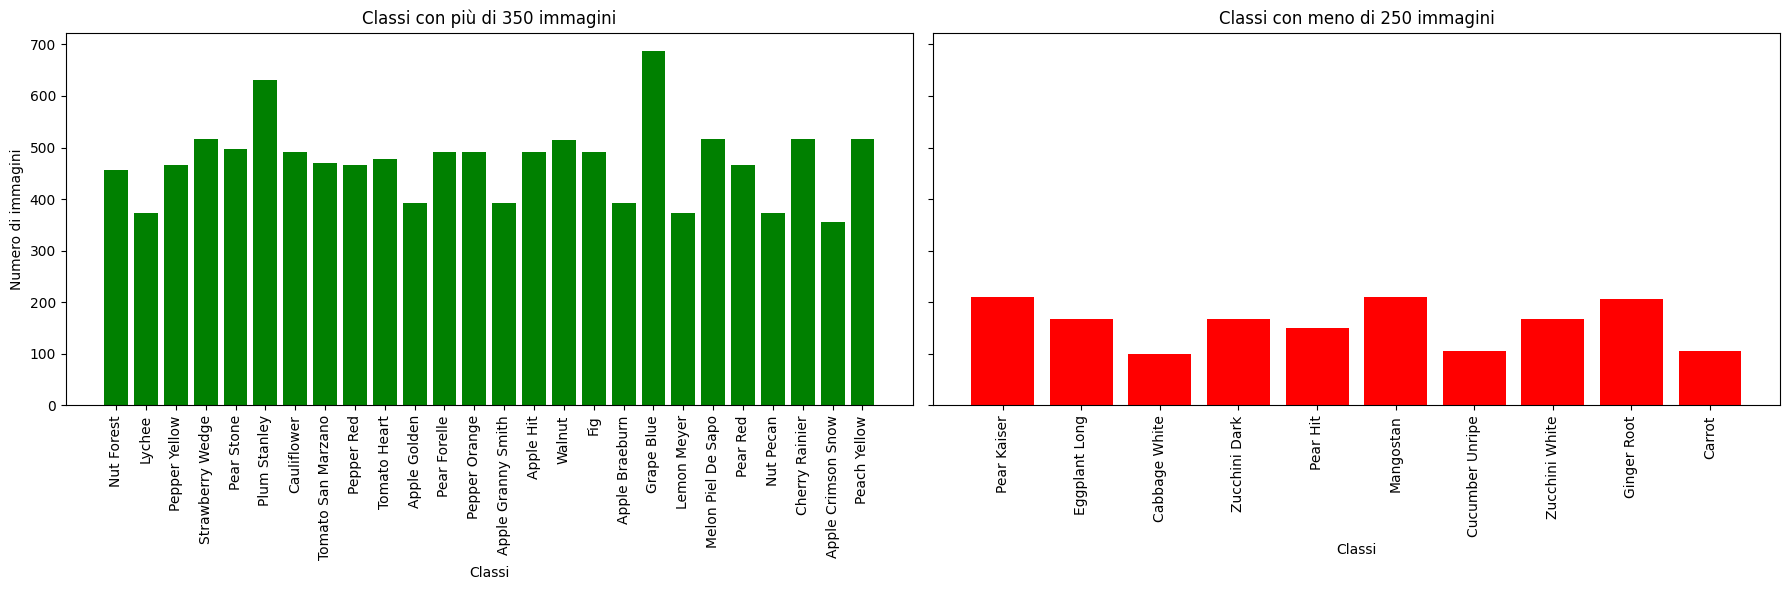

In [17]:
# Converti one-hot encoding in indici delle classi
class_indices = np.argmax(y2_train, axis=1)

# Conta le occorrenze di ogni classe
class_counts = Counter(class_indices)

# Filtra le classi con meno di 250 e più di 350 immagini
class_over_350 = {label_names_y2[idx]: count for idx, count in class_counts.items() if count > 350}
class_under_250 = {label_names_y2[idx]: count for idx, count in class_counts.items() if count < 250}

# Imposta la figura con due subplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Grafico per le classi con più di 350 immagini
axes[0].bar(class_over_350.keys(), class_over_350.values(), color='green')
axes[0].set_xlabel('Classi')
axes[0].set_ylabel('Numero di immagini')
axes[0].set_title('Classi con più di 350 immagini')
axes[0].tick_params(axis='x', rotation=90)

# Grafico per le classi con meno di 250 immagini
axes[1].bar(class_under_250.keys(), class_under_250.values(), color='red')
axes[1].set_xlabel('Classi')
axes[1].set_title('Classi con meno di 250 immagini')
axes[1].tick_params(axis='x', rotation=90)

# Mostra il grafico
plt.tight_layout()
plt.show()

Dal grafico risulta evidente che ci siamo molte sotto-classi che hanno più di 350 sample e potrebbero portare ad una classificazione sbilanciata. Allo stesso modo, seppur in numero minore, la stessa ossrevazione vale anche per le classi undersamplate.

Per questo motivo potrebbe dunque essere sensato nella fase di preparazione dati potremmo pensare di fare il calcolo dei pesi da assegnare a ciascuna classe per evitare di avere una classificazione spilanciata

#### Studio frequenze per label_1 (classe principale)

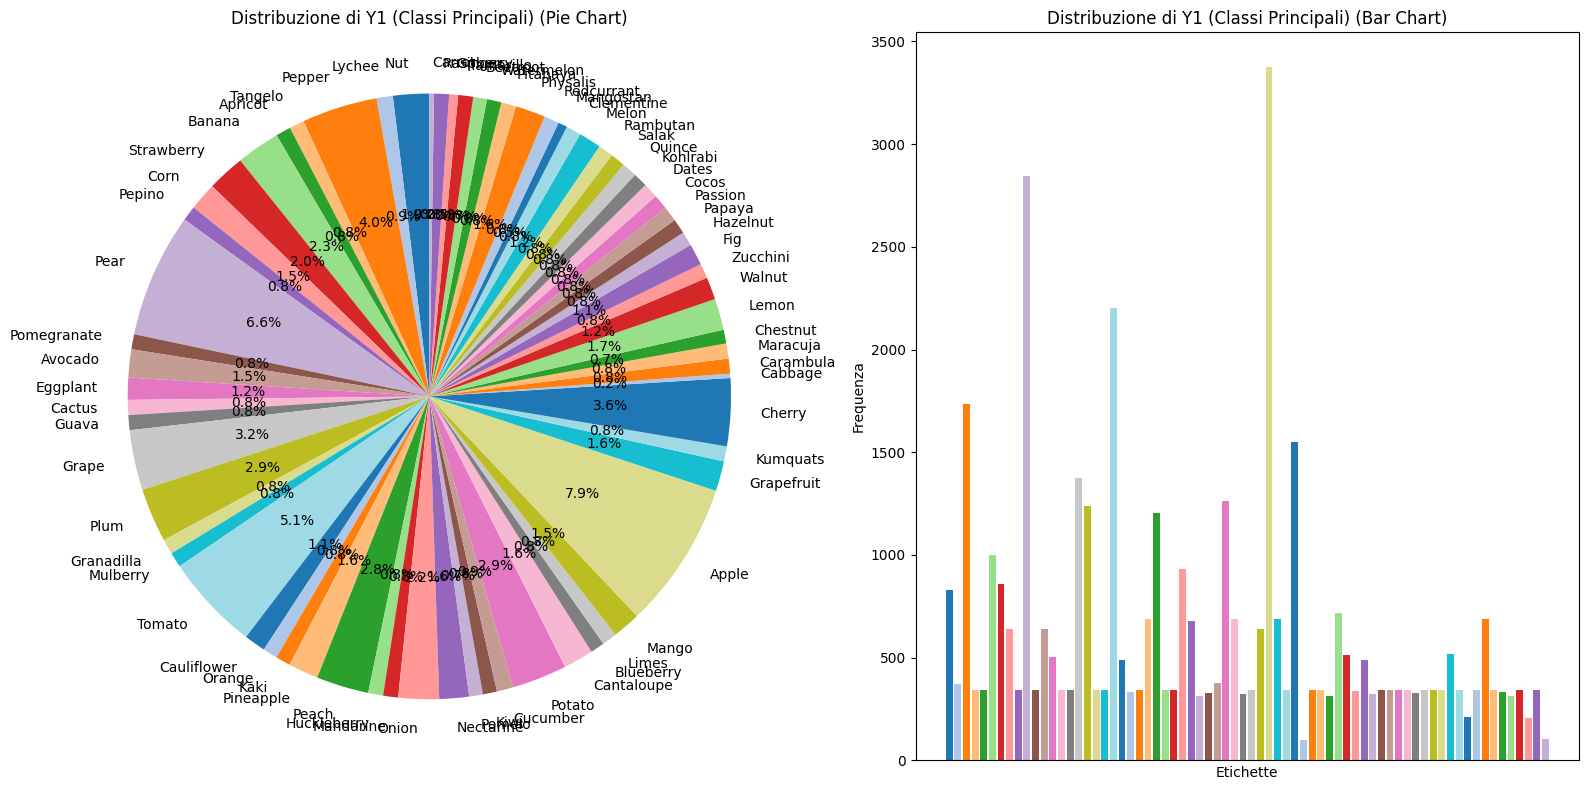

In [18]:
# Plot distribuzione di y1_train
label_names_y1 = list(labels_1_int.keys())  # Nomi per y1
plot_label_distribution(y1_train, label_names_y1, title="Distribuzione di Y1 (Classi Principali)")

In questo caso la differenza di esempi per ogni classe diventa molto più evidente, anche senza bisogno di fare un'analisi più dettagliata come per le label precedenti, per questo motivo si decide di calcolare dei pesi da assegnare a ciascuna classe anche per questa label

## Preparazione dei dati

Questo step è già stato in gran parte svolto sia nella preparazione manulae del dataset che poi anche nel momento in cui si è definita la funzione che salva i file npz. Abbiamo infatti che in questa funzione ci si assicura anche che tutte le immaigni vengano salvate con la stessa dimensione standard (128,128) e che i valori di tutti e 3 canali di RGB siano sempre compresi tra 0 e 255 per tutte le immagini. Inoltre è anche già stato fatto il one-hot delle labels in fase di pre-processing. Di conseguenza, non ci rimangono

### Calcolo pesi di bilaciamento per ogni classe

Si definisce la seguente funzione per trovare i pesi da assegnare a ciasscuna classe (sia per label 1 che per label 2)

In [19]:
def compute_class_weights(y_train):
    # Converti one-hot encoding in indici delle classi
    class_indices = np.argmax(y_train, axis=1)

    # Conta le occorrenze di ogni classe
    class_counts = Counter(class_indices)

    # Numero totale di sample e di classi
    total_samples = len(class_indices)
    num_classes = len(class_counts)

    # Calcola i pesi: più rara è la classe, più alto è il peso
    class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}

    return class_weights

#### Calcolo pesi bilanciamento sotto-classi (label-2)

In [20]:
# Calcola i pesi per y2
class_weights_y2 = compute_class_weights(y2_train)

# Mostra i pesi calcolati
print("Pesi per y2_train:", class_weights_y2)

Pesi per y2_train: {np.int64(66): 0.7627510629592072, np.int64(56): 0.9345234203012271, np.int64(89): 0.7480198192539865, np.int64(112): 1.016260162601626, np.int64(9): 1.0133059179429003, np.int64(14): 1.016260162601626, np.int64(110): 0.6755372786286002, np.int64(32): 1.0791864884593119, np.int64(85): 1.016260162601626, np.int64(83): 0.7013626474292912, np.int64(98): 1.0133059179429003, np.int64(10): 1.016260162601626, np.int64(36): 1.0343538153482426, np.int64(18): 1.016260162601626, np.int64(80): 1.6598915989159893, np.int64(46): 1.016260162601626, np.int64(43): 1.016260162601626, np.int64(97): 0.5532971996386631, np.int64(40): 1.016260162601626, np.int64(63): 1.0133059179429003, np.int64(113): 1.0133059179429003, np.int64(23): 0.7099332704121338, np.int64(71): 1.040529062007038, np.int64(49): 1.016260162601626, np.int64(93): 1.0103687993401673, np.int64(116): 1.0531034313364283, np.int64(75): 1.0133059179429003, np.int64(48): 1.016260162601626, np.int64(117): 0.741653693132676, np

#### Calcolo pesi bilanciamento classi principali (label-1)

In [21]:
# Calcola i pesi per y1
class_weights_y1 = compute_class_weights(y1_train)

# Mostra i pesi calcolati
print("Pesi per y1_train:", class_weights_y1)

Pesi per y1_train: {np.int64(42): 0.7379518072289156, np.int64(34): 1.6420911528150135, np.int64(50): 0.3534333525678015, np.int64(65): 1.7857142857142858, np.int64(1): 1.7805232558139534, np.int64(3): 0.6118881118881119, np.int64(63): 0.7122093023255814, np.int64(16): 0.9600313479623824, np.int64(49): 1.7857142857142858, np.int64(48): 0.21544143510376362, np.int64(55): 1.7805232558139534, np.int64(2): 0.9555382215288611, np.int64(19): 1.2128712871287128, np.int64(7): 1.7857142857142858, np.int64(25): 1.7857142857142858, np.int64(23): 0.44545454545454544, np.int64(54): 0.4955501618122977, np.int64(22): 1.7857142857142858, np.int64(40): 1.7805232558139534, np.int64(66): 0.2784090909090909, np.int64(11): 1.2474541751527495, np.int64(44): 1.828358208955224, np.int64(28): 1.7857142857142858, np.int64(52): 0.8902616279069767, np.int64(47): 0.5087209302325582, np.int64(27): 1.7857142857142858, np.int64(35): 1.7857142857142858, np.int64(43): 0.6571888412017167, np.int64(41): 0.900735294117647

### Calcolo pesi di bilanciamento per samples

Keras sfortunatamente non supporta direttamente class_weight per modelli con più output. (Che è esattamente il tipo di modello che vogliamo sviluppare in questo progetto). Possiamo però raggirare il problema usando i pesi manuali per ciascun output, sfruttando sample_weight invece di class_weight. Di seguito si calcolano quindi i pesi manuali da aasegnare ai sample:

In [22]:
def compute_sample_weights(y_train, class_weights):
    # Converti da one-hot a indici delle classi
    class_indices = np.argmax(y_train, axis=1)

    # Assegna il peso corrispondente a ciascun sample
    sample_weights = np.array([class_weights[idx] for idx in class_indices])

    return sample_weights

#### Calcolo pesi bilanciamento sotto-classi (label-2)

In [23]:
# Genera i pesi per ogni sample
sample_weights_y2 =  np.array(compute_sample_weights(y2_train, class_weights_y2))

#### Calcolo pesi bilanciamento classi principali (label-1)

In [24]:
# Genera i pesi per ogni sample
sample_weights_y1 = np.array( compute_sample_weights(y1_train, class_weights_y1) )

#### Calcolo pesi condivisi

Siccome abbiamo che nella rete i layer che identificano le labe_1 e label_2 sono condivise possiamo mergiare questi pesi nel seguente modo:

In [25]:
# Combine sample weights for y1 and y2
combined_sample_weights = (sample_weights_y1 + sample_weights_y2) / 2

### Controllo conformità dati

In [26]:
def check_data_conformity(x, y1, y2, sample_weights_y1=None, sample_weights_y2=None, dataset_name="train"):
    errors = []

    # 1 Controllo dimensione dataset
    num_samples = x.shape[0]

    if y1.shape[0] != num_samples:
        errors.append(f"❌ {dataset_name}: y1 ha {y1.shape[0]} campioni, ma x ne ha {num_samples}")

    if y2.shape[0] != num_samples:
        errors.append(f"❌ {dataset_name}: y2 ha {y2.shape[0]} campioni, ma x ne ha {num_samples}")

    # 2️ Controllo se le etichette sono one-hot encoded
    if len(y1.shape) != 2:
        errors.append(f"❌ {dataset_name}: y1 dovrebbe essere one-hot encoded (shape 2D), ma ha shape {y1.shape}")

    if len(y2.shape) != 2:
        errors.append(f"❌ {dataset_name}: y2 dovrebbe essere one-hot encoded (shape 2D), ma ha shape {y2.shape}")

    # 3️ Controllo sample_weights per y1
    if sample_weights_y1 is not None:
        if sample_weights_y1.shape[0] != num_samples:
            errors.append(f"❌ {dataset_name}: sample_weights_y1 ha {sample_weights_y1.shape[0]} campioni, ma x ne ha {num_samples}")

    # 4️ Controllo sample_weights per y2
    if sample_weights_y2 is not None:
        if sample_weights_y2.shape[0] != num_samples:
            errors.append(f"❌ {dataset_name}: sample_weights_y2 ha {sample_weights_y2.shape[0]} campioni, ma x ne ha {num_samples}")

    # Se non ci sono errori, tutto è conforme
    if not errors:
        print(f"✅ {dataset_name}: Tutti i dati sono conformi!")
    else:
        for error in errors:
            print(error)

In [27]:
check_data_conformity(x_train, y1_train, y2_train, sample_weights_y1, sample_weights_y2, dataset_name="Train")
check_data_conformity(x_val, y1_val, y2_val, dataset_name="Validation")
check_data_conformity(x_test, y1_test, y2_test, dataset_name="Test")

✅ Train: Tutti i dati sono conformi!
✅ Validation: Tutti i dati sono conformi!
✅ Test: Tutti i dati sono conformi!


## Costruzione dei modelli

### Modello ???: Rete neurale fatta da zero

In [36]:
# Definisci la CNN con due rami
def build_model(input_shape, num_classes, num_object_names):
    # Input per l'immagine
    img_input = Input(shape=input_shape)

    # Struttura condivisa della CNN
    x = Conv2D(32, (3, 3), activation='relu')(img_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Ramo 1 (Classificazione della classe)
    class_output = Dense(num_classes, activation='softmax', name='y1')(x)

    # Ramo 2 (Classificazione del nome oggetto)
    object_output = Dense(num_object_names, activation='softmax', name='y2')(x)

    # Modello finale
    model = Model(inputs=img_input, outputs=[class_output, object_output])

    return model

In [37]:
# Costruisci il modello
batch_size = 32

In [38]:
input_shape = x_train.shape[1:]
num_classes_1 = len(y1_train[0])
num_classes_2 = len(y2_train[0])
model = build_model(input_shape, num_classes_1, num_classes_2)

# Compilazione del modello
model.compile(
    optimizer='adam',
    loss={
            'y1': 'categorical_crossentropy',
            'y2': 'categorical_crossentropy'
        },
    metrics={
        'y1': 'accuracy',
        'y2': 'accuracy'
    }
)

In [ ]:
model.summary()

In [ ]:
# Calcola il numero totale di campioni
num_train_samples = len(x_train)
num_val_samples = len(x_val)

# Calcoliamo gli steps corretti
steps_per_epoch = np.ceil(num_train_samples / batch_size).astype(int)
validation_steps = np.ceil(num_val_samples / batch_size).astype(int)

In [ ]:
# Addestramento del modello
history = model.fit(x_train,
                    {
                        'y1': y1_train,
                        'y2': y2_train
                    },
                    validation_data=(
                        x_val,
                        {
                            'y1': y1_val,
                            'y2': y2_val
                        }
                    ),
                    epochs=20,
                    steps_per_epoch=steps_per_epoch,  # Numero di batch per epoca
                    validation_steps=validation_steps,  # Numero di batch per epoca
                    batch_size=batch_size,
                    #sample_weight=combined_sample_weights
                    )

### Modello ResNet

In [ ]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)

# 🔴 Ramo 1 - Predizione del Frutto
fruit_output = layers.Dense(num_classes_1, activation="softmax", name="y1")(x)

# 🔵 Ramo 2 - Predizione della Qualità
quality_output = layers.Dense(num_classes_2, activation="softmax", name="y2")(x)
model = Model(inputs=base_model.input, outputs=[fruit_output, quality_output])
model.summary()

In [ ]:
input_shape = x_train.shape[1:]
num_classes_1 = len(y1_train[0])
num_classes_2 = len(y2_train[0])

model.compile(
    optimizer='adam',
    loss={
            'y1': 'categorical_crossentropy',
            'y2': 'categorical_crossentropy'
        },
    metrics={
        'y1': 'accuracy',
        'y2': 'accuracy'
    }
)

In [ ]:
history = model.fit(x_train,
                    {
                        'y1': y1_train,
                        'y2': y2_train
                    },
                    validation_data=(
                        x_val,
                        {
                            'y1': y1_val,
                            'y2': y2_val
                        }
                    ),
                    epochs=10,
                    batch_size=256
                    )

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 5))

# 🔴 Grafico della Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
plt.plot(epochs, history.history['y1_loss'], 'b-', label='Y1 (Fruit) Loss')
plt.plot(epochs, history.history['val_y1_loss'], 'b--', label='Val Y1 Loss')
plt.plot(epochs, history.history['y2_loss'], 'g-', label='Y2 (Quality) Loss')
plt.plot(epochs, history.history['val_y2_loss'], 'g--', label='Val Y2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

# 🔵 Grafico della Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['y1_accuracy'], 'b-', label='Y1 (Fruit) Accuracy')
plt.plot(epochs, history.history['val_y1_accuracy'], 'b--', label='Val Y1 Accuracy')
plt.plot(epochs, history.history['y2_accuracy'], 'g-', label='Y2 (Quality) Accuracy')
plt.plot(epochs, history.history['val_y2_accuracy'], 'g--', label='Val Y2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.show()

### Modello VGG

In [31]:
# Carica il modello VGG19 pre-addestrato
VGG_model = VGG19(weights='imagenet', 
                   include_top=False, 
                   input_shape=(128, 128, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 42s 1us/step


In [32]:
VGG_model.trainable = False  # Blocca i pesi del modello pre-addestrato

In [39]:
# Aggiungi strati personalizzati
x = layers.GlobalAveragePooling2D()(VGG_model.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)

# 🔴 Ramo 1 - Predizione del Frutto
fruit_output = layers.Dense(num_classes_1, activation="softmax", name="y1")(x)

# 🔵 Ramo 2 - Predizione della Qualità
quality_output = layers.Dense(num_classes_2, activation="softmax", name="y2")(x)

In [40]:
# Crea il modello con doppia uscita
model = Model(inputs=VGG_model.input, outputs=[fruit_output, quality_output])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 32, 32,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 16, 16,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv4[0][

 Total params: 20,213,505 (77.11 MB)

 Trainable params: 189,121 (738.75 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [41]:
# Definisci il numero di classi
num_classes_1 = len(y1_train[0])  # Classi dei frutti
num_classes_2 = len(y2_train[0])  # Classi della qualità

# Compila il modello
model.compile(
    optimizer='adam',

    loss={
        'y1': 'categorical_crossentropy', 
        'y2': 'categorical_crossentropy'
        },

    metrics={
        'y1': 'accuracy', 
        'y2': 'accuracy'
        }
)

In [42]:
# Addestramento del modello
history = model.fit(
    x_train,
    {'y1': y1_train, 
     'y2': y2_train},
    validation_data=(
        x_val, {
            'y1': y1_val, 
            'y2': y2_val}),
    epochs=10,
    batch_size=256
)

# Visualizzazione delle metriche di addestramento
epochs = range(1, len(history.history['loss']) + 1)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2676s 16s/step - loss: 7.7184 - y1_accuracy: 0.1820 - y1_loss: 3.4394 - y2_accuracy: 0.0927 - y2_loss: 4.2789 - val_loss: 2.9444 - val_y1_accuracy: 0.6528 - val_y1_loss: 1.2565 - val_y2_accuracy: 0.6439 - val_y2_loss: 1.6394
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2567s 15s/step - loss: 2.7691 - y1_accuracy: 0.6234 - y1_loss: 1.2654 - y2_accuracy: 0.6221 - y2_loss: 1.5037 - val_loss: 1.2610 - val_y1_accuracy: 0.8261 - val_y1_loss: 0.6171 - val_y2_accuracy: 0.8776 - val_y2_loss: 0.6089
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2517s 15s/step - loss: 1.4966 - y1_accuracy: 0.7745 - y1_loss: 0.7508 - y2_accuracy: 0.8088 - y2_loss: 0.7458 - val_loss: 0.7423 - val_y1_accuracy: 0.8961 - val_y1_loss: 0.3836 - val_y2_accuracy: 0.9243 - val_y2_loss: 0.3407
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2582s 15s/step - loss: 1.0004 - y1_accuracy: 0.8434 - y1_loss: 0.5216 - y2_accuracy: 0.8731 - y2_loss: 0.4789 - val_loss: 0.4920 - val_y1_accuracy: 0.9224 - val_y1_l

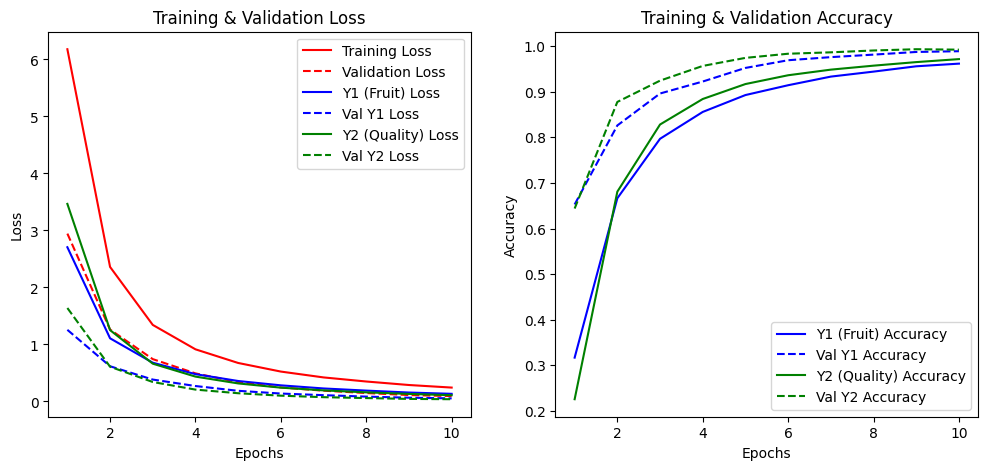

In [43]:
plt.figure(figsize=(12, 5))

# 🔴 Grafico della Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
plt.plot(epochs, history.history['y1_loss'], 'b-', label='Y1 (Fruit) Loss')
plt.plot(epochs, history.history['val_y1_loss'], 'b--', label='Val Y1 Loss')
plt.plot(epochs, history.history['y2_loss'], 'g-', label='Y2 (Quality) Loss')
plt.plot(epochs, history.history['val_y2_loss'], 'g--', label='Val Y2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

# 🔵 Grafico della Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['y1_accuracy'], 'b-', label='Y1 (Fruit) Accuracy')
plt.plot(epochs, history.history['val_y1_accuracy'], 'b--', label='Val Y1 Accuracy')
plt.plot(epochs, history.history['y2_accuracy'], 'g-', label='Y2 (Quality) Accuracy')
plt.plot(epochs, history.history['val_y2_accuracy'], 'g--', label='Val Y2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.show()

In [45]:
model.save("modelVGG19Keras.keras")

### Model VGG19 due (+ epoche, - batch_size, early_stopping, - dropout)

In [46]:
# Carica il modello VGG19 pre-addestrato
VGG_model2 = VGG19(weights='imagenet', 
                   include_top=False, 
                   input_shape=(128, 128, 3))

In [47]:
VGG_model2.trainable = False  # Blocca i pesi del modello pre-addestrato

In [48]:
# Aggiungi strati personalizzati
x = layers.GlobalAveragePooling2D()(VGG_model2.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)

# 🔴 Ramo 1 - Predizione del Frutto
fruit_output = layers.Dense(num_classes_1, activation="softmax", name="y1")(x)

# 🔵 Ramo 2 - Predizione della Qualità
quality_output = layers.Dense(num_classes_2, activation="softmax", name="y2")(x)

In [49]:
# Crea il modello con doppia uscita
model2 = Model(inputs=VGG_model2.input, outputs=[fruit_output, quality_output])
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 32, 32,    │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 16, 16,    │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv4[0][

 Total params: 20,213,505 (77.11 MB)

 Trainable params: 189,121 (738.75 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [50]:
# Definisci il numero di classi
num_classes_1 = len(y1_train[0])  # Classi dei frutti
num_classes_2 = len(y2_train[0])  # Classi della qualità

# Compila il modello
model2.compile(
    optimizer='adam',

    loss={
        'y1': 'categorical_crossentropy', 
        'y2': 'categorical_crossentropy'
        },

    metrics={
        'y1': 'accuracy', 
        'y2': 'accuracy'
        }
)

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",  # Controlla la perdita sulla validation set
    patience=2,          # Numero di epoche senza miglioramento prima di fermarsi
    restore_best_weights=True # Ripristina i migliori pesi trovati
)

# Addestramento del modello
history2 = model2.fit(
    x_train,
    {'y1': y1_train, 
     'y2': y2_train},
    validation_data=(
        x_val, {
            'y1': y1_val, 
            'y2': y2_val}),
    epochs=20,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 2041s 6s/step - loss: 6.5781 - y1_accuracy: 0.2817 - y1_loss: 2.9194 - y2_accuracy: 0.2027 - y2_loss: 3.6587 - val_loss: 1.5620 - val_y1_accuracy: 0.7948 - val_y1_loss: 0.7409 - val_y2_accuracy: 0.8219 - val_y2_loss: 0.8075
Epoch 2/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 2027s 6s/step - loss: 1.5542 - y1_accuracy: 0.7718 - y1_loss: 0.7660 - y2_accuracy: 0.7970 - y2_loss: 0.7882 - val_loss: 0.6572 - val_y1_accuracy: 0.9095 - val_y1_loss: 0.3450 - val_y2_accuracy: 0.9287 - val_y2_loss: 0.3044
Epoch 3/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 2017s 6s/step - loss: 0.7850 - y1_accuracy: 0.8765 - y1_loss: 0.4149 - y2_accuracy: 0.9018 - y2_loss: 0.3701 - val_loss: 0.3724 - val_y1_accuracy: 0.9478 - val_y1_loss: 0.2013 - val_y2_accuracy: 0.9593 - val_y2_loss: 0.1654
Epoch 4/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 2024s 6s/step - loss: 0.5029 - y1_accuracy: 0.9176 - y1_loss: 0.2726 - y2_accuracy: 0.9389 - y2_loss: 0.2303 - val_loss: 0.2323 - val_y1_accuracy: 0.9655 - val_y1_loss:

In [52]:
def plot_training_history(history):
    """
    Visualizza i grafici di loss e accuracy per un modello con due output.
    
    Args:
        history: Storia dell'addestramento del modello (output di model.fit())
    """
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # 🔴 Grafico della Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
    plt.plot(epochs, history.history['y1_loss'], 'b-', label='Y1 (Fruit) Loss')
    plt.plot(epochs, history.history['val_y1_loss'], 'b--', label='Val Y1 Loss')
    plt.plot(epochs, history.history['y2_loss'], 'g-', label='Y2 (Quality) Loss')
    plt.plot(epochs, history.history['val_y2_loss'], 'g--', label='Val Y2 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    
    # 🔵 Grafico della Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['y1_accuracy'], 'b-', label='Y1 (Fruit) Accuracy')
    plt.plot(epochs, history.history['val_y1_accuracy'], 'b--', label='Val Y1 Accuracy')
    plt.plot(epochs, history.history['y2_accuracy'], 'g-', label='Y2 (Quality) Accuracy')
    plt.plot(epochs, history.history['val_y2_accuracy'], 'g--', label='Val Y2 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')
    
    plt.tight_layout()
    plt.show()

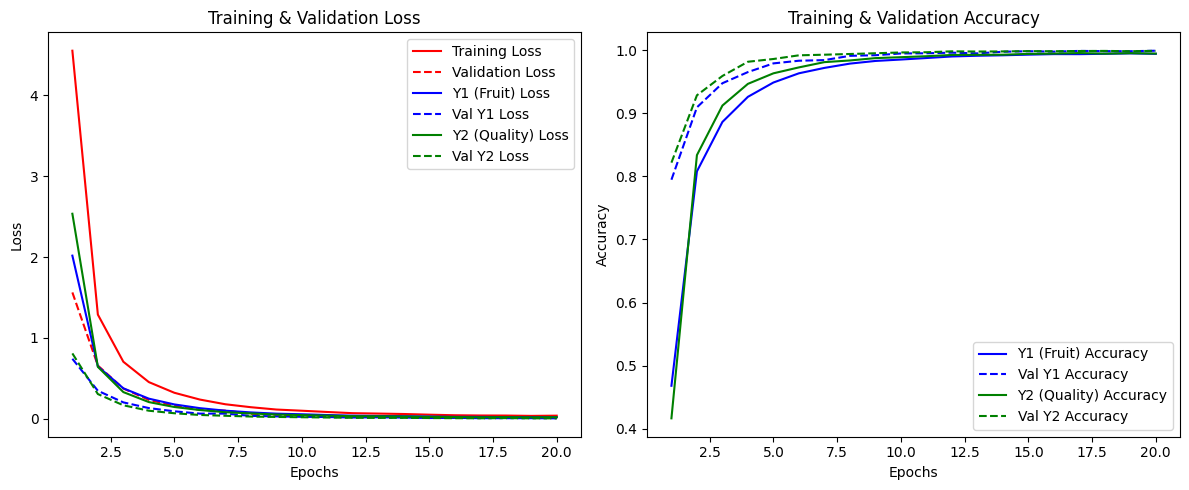

In [53]:
# Dopo l'addestramento del modello
plot_training_history(history2)

In [54]:
model2.save("modelVGG19Keras2.keras")